# Bias-Variance Tradeoff


## Agenda

1. Revisit the goal of model building, and relate it to expected value, bias and variance
2. Defining Error: prediction error and irreducible error
3. Define prediction error as a combination of bias and variance
4. Explore the bias-variance tradeoff
5. Code a basic train-test split
6. Code K-Folds



# 1. Revisit the goal of model building, and relate it to expected value, bias and variance

![which model is better](img/which_model_is_better.png)


# What makes a model good?

- We don’t ultimately care about how well your model fits your data.

- What we really care about is how well your model describes the process that generated your data.

- Why? Because the data set you have is but one sample from a universe of possible data sets, and you want a model that would work for any data set from that universe

# What is a “Model”?

 - A “model” is a general specification of relationships among variables. 
     - E.G. Linear Regression: or $ Price = \beta_1*Y_{t-1} +  \beta_0 + \epsilon$


 

 - A “trained model” is a particular model with parameters estimated using some training data.

# Remember Expected Value? How is it connected to bias and variance?
- The expected value of a quantity is the weighted average of that quantity across all possible samples

![6 sided die](https://media.giphy.com/media/sRJdpUSr7W0AiQ3RcM/giphy.gif)

- for a 6 sided die, another way to think about the expected value is the arithmetic mean of the rolls of a very large number of independent samples.  

### The expected value of a 6-sided die is:

In [1]:
probs = 1/6
rolls = range(1,7)

expected_value = sum([probs * roll for roll in rolls])
expected_value

3.5

Now lets imagine we create a model that always predicts a roll of 3.

   
  - The bias is the difference between the average prediction of our model and the average roll of the die as we roll more and more times.
        - What is the bias of a model that alway predicts 3?         
 - Bias = 3.5 - 3 = 0.5
   

   - The variance is the average difference between each individual prediction and the average prediction of our model as we roll more and more times.
        - What is the variance of that model?
 - Variance = 3 - 3 = 0

# 2. Defining Error: prediction error and irreducible error



### Regression fit statistics are often called “error”
 - Sum of Squared Errors (SSE)
 $ {\displaystyle \operatorname {SSE} =\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}.} $
 - Mean Squared Error (MSE) 
 
 $ {\displaystyle \operatorname {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}.} $
 
 - Root Mean Squared Error (RMSE)  
 $ {\displaystyle \operatorname 
  {RMSE} =\sqrt{MSE}} $

 All are calculated using residuals    

![residuals](img/residuals.png)


## This error can be broken up into parts:

![defining error](img/defining_error.png)

There will always be some random, irreducible error inherent in the data.  Real data always has noise.

The goal of modeling is to reduce the prediction error, which is the difference between our model and the realworld processes from which our data is generated.

# 3. Define prediction error as a combination of bias and variance

$\Large Total\ Error\ = Prediction\ Error+ Irreducible\ Error$

Our prediction error can be further broken down into error due to bias and error due to variance.

$\Large Total\ Error = Model\ Bias^2 + Model\ Variance + Irreducible\ Error$



**Model Bias** is the expected prediction error of the expected trained model

> In other words, if you were to train multiple models on different samples, what would be the average difference between the prediction and the real value.

**Model Variance** is the expected variation in predictions, relative to your expected trained model

> In other words, what would be the average difference between any one model's prediction and the average of all the predictions .



# Thought Experiment

1. Imagine you've collected 23 different training sets for the same problem.
2. Now imagine training one model on each of your 23 training sets.
3. Bias vs. variance refers to the accuracy vs. consistency of the models trained by your algorithm.

![target_bias_variance](img/target.png)

http://scott.fortmann-roe.com/docs/BiasVariance.html



### Let's take a look at our familiar King County housing data. 

After some EDA, we have decided to choose 11 independent features predicting 1 target variable, price.

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/king_county.csv', index_col='id')
df = df.iloc[:,:12]
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
id,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0


Let's create a set of 100 trained models by randomly selecting 1000 records, and look at the difference in predictions w.r.t. 1 point.

In [2]:
np.random.seed(11)

# Reserve a random sample point for demonstration of bias/variance 
sample_point = df.sample(1)
true_sample_price = sample_point.price

In [3]:
sample_point.drop('price', axis=1, inplace=True)

print(sample_point.head())

          bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
id                                                                         
34000005         2        1.0         1100      4200     1.0           0   

          view  condition  grade  sqft_above  sqft_basement  
id                                                           
34000005     0          3      7        1100              0  


In [4]:
print(f'Sample home price {true_sample_price.values[0]}')

Sample home price 343566.0


In [5]:
# Remove sample from data set we will train our model on
df.drop(true_sample_price.index[0], axis=0, inplace=True)
print(df.shape)

(21612, 12)


In [6]:
### from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
np.random.seed(11)

# Let's generate random subsets of our data

point_preds_simp = []
simple_rmse = []

for i in range(100):
    
    # Sample 1000 random homes
    df_sample = df.sample(1000, replace=True)
    y = df_sample.price
    X = df_sample.drop('price', axis=1)
    
    # Create a trained model for each subset
    lr = LinearRegression()
    lr.fit(X, y)
    
    y_hat = lr.predict(X)
    
    # Calculate RMSE for each trained model
    simple_rmse.append(np.sqrt(mean_squared_error(y, y_hat)))
    
    # Predict a value for the sample point
    y_hat_point = lr.predict(sample_point)[0]
    point_preds_simp.append(y_hat_point)
    


Now let's use sklearn's polynomial transformation to create a relatively complex version of our model.  
[Poly_transform blog](https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/)


In [7]:
from sklearn.preprocessing import PolynomialFeatures

# This will create a feature set of each feature squared, as well as interaction features between each independent variable.
pf = PolynomialFeatures(2, include_bias=False)

df_poly = pd.DataFrame(pf.fit_transform(df.drop('price', axis=1)))
df_poly.index = df.index
df_poly['price'] = df['price']

cols = list(df_poly)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('price')))

df_poly = df_poly.loc[:,cols]

df_poly.head(10)

,price,0,1,2,3,4,5,6,7,8,...,67,68,69,70,71,72,73,74,75,76
id,,,,,,,,,,,,,,,,,,,,,
7129300520,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,...,9.0,21.0,3540.0,0.0,49.0,8260.0,0.0,1392400.0,0.0,0.0
6414100192,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,...,9.0,21.0,6510.0,1200.0,49.0,15190.0,2800.0,4708900.0,868000.0,160000.0
5631500400,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,...,9.0,18.0,2310.0,0.0,36.0,4620.0,0.0,592900.0,0.0,0.0
2487200875,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,...,25.0,35.0,5250.0,4550.0,49.0,7350.0,6370.0,1102500.0,955500.0,828100.0
1954400510,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,...,9.0,24.0,5040.0,0.0,64.0,13440.0,0.0,2822400.0,0.0,0.0
7237550310,1225000.0,4.0,4.50,5420.0,101930.0,1.0,0.0,0.0,3.0,11.0,...,9.0,33.0,11670.0,4590.0,121.0,42790.0,16830.0,15132100.0,5951700.0,2340900.0
1321400060,257500.0,3.0,2.25,1715.0,6819.0,2.0,0.0,0.0,3.0,7.0,...,9.0,21.0,5145.0,0.0,49.0,12005.0,0.0,2941225.0,0.0,0.0
2008000270,291850.0,3.0,1.50,1060.0,9711.0,1.0,0.0,0.0,3.0,7.0,...,9.0,21.0,3180.0,0.0,49.0,7420.0,0.0,1123600.0,0.0,0.0
2414600126,229500.0,3.0,1.00,1780.0,7470.0,1.0,0.0,0.0,3.0,7.0,...,9.0,21.0,3150.0,2190.0,49.0,7350.0,5110.0,1102500.0,766500.0,532900.0


In [8]:
# Isolate the poly-transformed version of our sample point
sample_point = pf.transform(sample_point)
sample_point

array([[2.000e+00, 1.000e+00, 1.100e+03, 4.200e+03, 1.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00, 7.000e+00, 1.100e+03, 0.000e+00, 4.000e+00,
        2.000e+00, 2.200e+03, 8.400e+03, 2.000e+00, 0.000e+00, 0.000e+00,
        6.000e+00, 1.400e+01, 2.200e+03, 0.000e+00, 1.000e+00, 1.100e+03,
        4.200e+03, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 7.000e+00,
        1.100e+03, 0.000e+00, 1.210e+06, 4.620e+06, 1.100e+03, 0.000e+00,
        0.000e+00, 3.300e+03, 7.700e+03, 1.210e+06, 0.000e+00, 1.764e+07,
        4.200e+03, 0.000e+00, 0.000e+00, 1.260e+04, 2.940e+04, 4.620e+06,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 7.000e+00,
        1.100e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 9.000e+00, 2.100e+01, 3.300e+03, 0.000e+00, 4.900e+01,
        7.700e+03, 0.000e+00, 1.210e+06, 0.000e+00, 0.000e+00]])

Then train 100 models using our complex features set on samples of size 5000.

In [9]:
np.random.seed(11)

point_preds_comp = []
complex_rmse = []
for i in range(100):
    
    df_sample = df_poly.sample(1000, replace=True)
    y = df_sample.price
    X = df_sample.drop('price', axis=1)
    
    lr = LinearRegression()
    lr.fit(X, y)
    y_hat = lr.predict(X)
    complex_rmse.append(np.sqrt(mean_squared_error(y, y_hat)))
    
    y_hat_point = lr.predict(sample_point)[0]
    
    point_preds_comp.append(y_hat_point)
    

In [10]:
print("#################### BIAS ###########################")
print(f'mean simple prediction      {np.mean(point_preds_simp)}')
print(f'mean complex prediction     {np.mean(point_preds_comp)}')
print(f'true value                  {true_sample_price}')
print("################## VARIANCE #########################")
print(f'simp variance {np.var(point_preds_simp)}')
print(f'comp variance {np.var(point_preds_comp)}')

#################### BIAS ###########################
mean simple prediction      310571.8686803037
mean complex prediction     351046.7474423822
true value                  id
34000005    343566.0
Name: price, dtype: float64
################## VARIANCE #########################
simp variance 375803221.95772856
comp variance 514573245.6915817


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


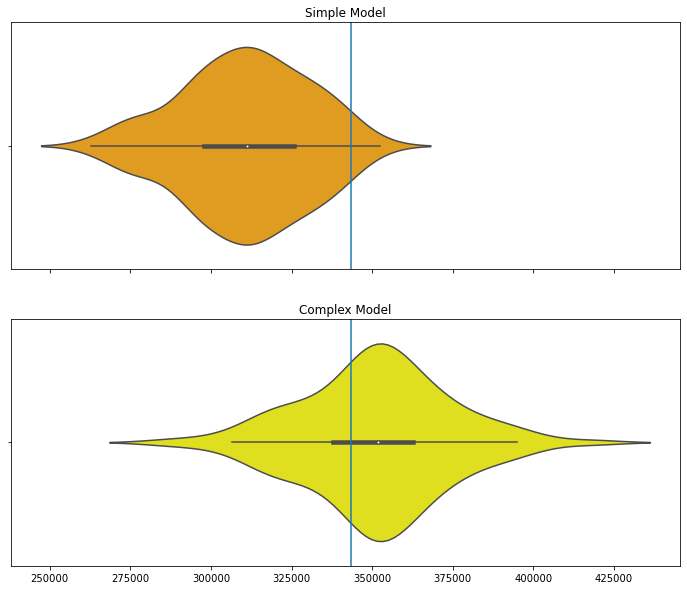

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,10))

sns.violinplot(point_preds_simp, ax=ax1, color='orange')
ax1.set_title("Simple Model")
ax1.axvline(true_sample_price.values[0])
sns.violinplot(point_preds_comp, ax=ax2, color='yellow')
ax2.axvline(true_sample_price.values[0])
ax2.set_title("Complex Model");

If you are curious after class, try fitting a 3rd order polynomial and plot the predictions w.r.t. the sample point. The mean of your predictions should align more tightly around the true value, but the variance should be much larger.


# 4.  Explore Bias Variance Tradeoff

**High bias** algorithms tend to be less complex, with simple or rigid underlying structure.

+ They train models that are consistent, but inaccurate on average.
+ These include linear or parametric algorithms such as regression and naive Bayes.
+ For linear, perhaps some assumptions about our feature set could lead to high bias. 
      - We did not include the correct predictors
      - We did not take interactions into account
      - In linear, we missed a non-linear relationship (polynomial). 
      
High bias models are **underfit**

On the other hand, **high variance** algorithms tend to be more complex, with flexible underlying structure.

+ They train models that are accurate on average, but inconsistent.
+ These include non-linear or non-parametric algorithms such as decision trees and nearest neighbors.
+ For linear, perhaps we included an unreasonably large amount of predictors. 
      - We created new features by squaring and cubing each feature
+ High variance models are modeling the noise in our data

High variance models are **overfit**



While we build our models, we have to keep this relationship in mind.  If we build complex models, we risk overfitting our models.  Their predictions will vary greatly when introduced to new data.  If our models are too simple, the predictions as a whole will be inaccurate.   

The goal is to build a model with enough complexity to be accurate, but not too much complexity to be erratic.

![optimal](img/optimal_bias_variance.png)
http://scott.fortmann-roe.com/docs/BiasVariance.html



![which_model](img/which_model_is_better_2.png)

# 5. Train Test Split

In [12]:
from sklearn.model_selection import train_test_split

It is hard to know if your model is too simple or complex by just using it on training data.

We can hold out part of our training sample, and use it as a test sample and use it to monitor our prediction error.

This allows us to evaluate whether our model has the right balance of bias/variance. 

<img src='img/testtrainsplit.png' width =550 />

* **training set** —a subset to train a model.
* **test set**—a subset to test the trained model.


In [13]:
import pandas as pd
df = pd.read_csv('data/king_county.csv', index_col='id')

y = df.price
X = df[['bedrooms', 'sqft_living']]

# For test size, we generally choose a number between .2 and .3.  
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = .25)

print(X_train.shape)
print(X_test.shape)

print(X_train.shape[0] == y_train.shape[0])
print(X_test.shape[0] == y_test.shape[0])

(16209, 2)
(5404, 2)
True
True


**How do we know if our model is overfitting or underfitting?**


If our model is not performing well on the training  data, we are probably underfitting it.  


To know if our  model is overfitting the data, we need  to test our model on unseen data. 
We then measure our performance on the unseen data. 

If the model performs way worse on the  unseen data, it is probably  overfitting the data.

<img src='https://developers.google.com/machine-learning/crash-course/images/WorkflowWithTestSet.svg' width=500/>

# QUIZ TIME

![](https://media.giphy.com/media/jNYUeDwoUoloEswJm8/giphy.gif)

### Should you ever fit on your test set?  


![no](https://media.giphy.com/media/d10dMmzqCYqQ0/giphy.gif)


**Never fit on test data.** If you are seeing surprisingly good results on your evaluation metrics, it might be a sign that you are accidentally training on the test set. 



Let's go back to our KC housing data without the polynomial transformation.

In [14]:
df = pd.read_csv('data/king_county.csv', index_col='id')

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
id,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0


Now, we create a train-test split via the sklearn model selection package.

In [15]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

y = df.price
X = df.drop('price', axis=1)

# Here is the convention for a traditional train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, test_size=.25)

In [16]:
# Instanstiate your linear regression object
lr = LinearRegression()

In [17]:
# fit the model on the training set
lr.fit(X_train, y_train)

LinearRegression()

In [18]:
# Check the R^2 of the training data
lr.score(X_train, y_train)

0.6076094372802432

Next, we test how well the model performs on the unseen test data. Remember, we do not fit the model again. The model has calculated the optimal parameters learning from the training set.  


In [19]:
lr.score(X_test, y_test)

0.598543548637533

The difference between the train and test scores are low.

What does that indicate about variance?

# Now, let's try the same thing with our complex, polynomial model.

In [20]:
df = pd.read_csv('data/king_county.csv', index_col='id')
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement
id,,,,,,,,,,,,
7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0
6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400
5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0
2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910
1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0


In [21]:
poly_2 = PolynomialFeatures(3, include_bias=False)

X_poly = pd.DataFrame(
            poly_2.fit_transform(df.drop('price', axis=1))
                      )

y = df.price
X_poly.head()

,0,1,2,3,4,5,6,7,8,9,...,353,354,355,356,357,358,359,360,361,362
0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,...,343.0,57820.0,0.0,9746800.0,0.0,0.0,1.643032e+09,0.000000e+00,0.0,0.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,...,343.0,106330.0,19600.0,32962300.0,6076000.0,1120000.0,1.021831e+10,1.883560e+09,347200000.0,64000000.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,...,216.0,27720.0,0.0,3557400.0,0.0,0.0,4.565330e+08,0.000000e+00,0.0,0.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,...,343.0,51450.0,44590.0,7717500.0,6688500.0,5796700.0,1.157625e+09,1.003275e+09,869505000.0,753571000.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,...,512.0,107520.0,0.0,22579200.0,0.0,0.0,4.741632e+09,0.000000e+00,0.0,0.0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=20, test_size=.25)
lr_poly = LinearRegression()

# Always fit on the training set
lr_poly.fit(X_train, y_train)

lr_poly.score(X_train, y_train)

0.7110231494908303

In [23]:
lr_poly.score(X_test, y_test)

0.5785203545199571

How do we interpret these results?

# Pair Exercise

##### [Thread](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data) about data leakage and scalars

The link above explains that if you are going to scale your data, you should only train your scaler on the training data to prevent data leakage.  

Perform the same train test split as shown above for the simple model, but now scale your data appropriately.  

The R2 for both train and test should be the same.


In [29]:
from sklearn.preprocessing import StandardScaler
np.random.seed(42)

y = df.price
X = df.drop('price', axis=1)

# Train test split with random_state=43 and test_size=.25
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, test_size=0.25)
# Instantiate an instance of Standard Scaler, and fit/transform on the training data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
# Transform the test data with the fit scalar
X_test_scaled = ss.transform(X_test)
# fit and score the model 
model = LinearRegression()
model.fit(X_train_scaled, y_train)
model.score(X_train_scaled, y_train)

0.6075957706900192

In [30]:
model.score(X_test_scaled, y_test)

0.5985805052032427

# Kfolds: Even More Rigorous Validation  

For a more rigorous cross-validation, we turn to K-folds

![kfolds](img/k_folds.png)

[image via sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)

In this process, we split the dataset into train and test as usual, then we perform a shuffling train test split on the train set.  

KFolds holds out one fraction of the dataset, trains on the larger fraction, then calculates a test score on the held out set.  It repeats this process until each group has served as the test set.

We tune our parameters on the training set using kfolds, then validate on the test data.  This allows us to build our model and check to see if it is overfit without touching the test data set.  This protects our model from bias.

# Fill in the Blank

In [28]:
X = df.drop('price', axis=1)
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, test_size=.25)

In [31]:
# A way to obtain cross validation scores with kfolds, 
# BUT this does not take into account if the training data was scaled
# i.e., the test data in the folds will have been scaled so you will have data leakage
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_train, y_train, cv=5)

array([0.61498886, 0.60746653, 0.61014067, 0.61703869, 0.58153935])

In [ ]:
from sklearn.model_selection import KFold

# Instantiate the KFold object
kf = KFold(n_splits=5)

train_r2 = []
test_r2 = []

# kf.split() splits the data via index
for train_ind, test_ind in kf.split(X_train,y_train):
    
    X_train_fold, y_train_fold = fill_in, fill_in
    X_validation, y_validation = fill_in, fill_in
    
    # fill in fit
    
    
    train_r2.append(lr.score(X_train_fold, y_train_fold))
    val_r2.append(lr.score(X_validation, y_validation))

In [ ]:
# Mean train r_2
np.mean(train_r2)

In [ ]:
# Mean test r_2
np.mean(val_r2)

### How do we use scalers with multiple fold cross validation

Keeping in mind that we only ever want to fit our transformers on the data we fit our predictive model on, let's replicate the code above to include a scaler into the cross validation process. 

In [ ]:
scaler = StandardScaler()

X = df.drop('price', axis=1)
y = df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43, test_size=.25)

kf = KFold(n_splits=5)

train_r2 = []
val_r2 = []
# Your code here


In [ ]:
# Mean train r_2
np.mean(train_r2)

In [ ]:
# Mean test r_2
np.mean(val_r2)

By using this split, we can use the training set as a test ground to build a model with both low bias and low variance.
We can test out new independent variables, try transformations, implement regularization, up/down sampling, without introducing bias into our model.

Once we have an acceptable model, we train our model on the entire training set, and score on the test to validate.



In [ ]:
lr_final = LinearRegression()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr_final.fit(X_train_scaled, y_train)

lr_final.score(X_test_scaled, y_test)